# Yelp Dataset



The **Yelp dataset** is a comprehensive collection of business, review, and user data sourced from Yelp’s platform. Originally created for the Yelp Dataset Challenge, this dataset includes businesses from **eight metropolitan areas across the United States and Canada**, offering valuable insights into consumer interactions and business attributes.

**Dataset Components:**

1. **business.json**– Contains business details, including location, attributes, and categories.
2. **review.json**– Stores full review text along with the corresponding user ID and business ID.
3. **user.json**– Includes user metadata, such as friend connections and activity metrics.
4. **checkin.json**– Tracks aggregated check-ins for businesses.
5. **tips.json**– Features concise user-submitted tips, typically shorter than full reviews.
6. **photos.json**- Stores user-uploaded photos and their respective categories.

**Dataset Overview:**

*   **5.2 million reviews** across **174,000 businesses**
*   **1.3 million users** contributing **1.1 million tips**
*   **200,000 images** categorized by users
*   **11 metropolitan areas** covered
*   **1.2 million business attributes**, including parking, ambience, availability, and operating hours

### Setting up Environment and Dataset API

In [1]:
!pip install -q scikit-surprise

In [2]:
!pip install numpy==1.23.5 scikit-surprise --force-reinstall

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Succ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
import json

from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction
from surprise.model_selection import train_test_split, cross_validate, KFold

my_seed = 1234

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marevi","key":"dbe1f1a5734a0df3ecb0a594be120310"}'}

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d yelp-dataset/yelp-dataset
!unzip yelp-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
Archive:  yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


### Loading Datasets & Preparation

Two of the largest datasets, **Review Data** and **User Data**, were too large to load in full without sampling. However, since the Yelp dataset includes various industries such as restaurants, beauty, and automotive services, we opted for a **natural sampling approach** by narrowing the data to only restaurant related entries. This ensures we retain all relevant information while reducing memory usage.

To achieve this, we first filtered the **Business Data** dataset by selecting only businesses categorized as restaurants. Then, we filtered all other datasets—**reviews, check-ins, users, and tips**—to include only records associated with those restaurant businesses.

#### **Loading Datasets**

##### **Business Data**
* **business_id**: 22 character unique string business id
* **name**: The business's name
* **city**: The city where the business is
* **state**: 2 character state code, if applicable
* **postal code**: The postal code of the business
* **latitude**: Latitude of the reviewed business
* **longitude**: Longitude of the reviewed business
* **stars**: Star rating of the business, rounded to half-stars
* **review_count**: Number of reviews of the business
* **is_open**: 0 or 1 for closed or open business, respectively
* **attributes**:	Business attributes to values, e.g., RestaurantsTakeOut and BusinessParking
* **categories**: An array of strings of business categories, e.g, "Mexican", "Burgers", "Gastropubs"
* **hours**: An object of key day to value hours, e.g., "Monday": "10:00-21:00"


*Variable Description Source: https://openbigdata.org/resource/yelp-open-dataset/*

In [2]:
import re

# Define chunk size for processing large files
chunk_size = 100000

# Function to filter businesses that are restaurants
def filter_restaurants_business(file_path):
    business_list = []
    with pd.read_json(file_path, lines=True, chunksize=chunk_size) as reader:
        for chunk in reader:
            chunk['categories'] = chunk['categories'].astype(str)  # Ensure categories is a string
            chunk['is_restaurant'] = chunk['categories'].str.contains(
                pat=r'restaurant', flags=re.IGNORECASE, regex=True, na=False
            )
            restaurant_chunk = chunk[chunk['is_restaurant']]
            business_list.append(restaurant_chunk)
    return pd.concat(business_list, ignore_index=True)

# Load and filter business dataset
restaurant_business_df = filter_restaurants_business("yelp_academic_dataset_business.json")

# Store restaurant business IDs for filtering other datasets
restaurant_business_ids = set(restaurant_business_df['business_id'])

print("Total Restaurant Businesses:", len(restaurant_business_ids))

Total Restaurant Businesses: 52286


In [3]:
business_df = pd.read_json("yelp_academic_dataset_business.json", lines=True)

# filtering for restaurants
restaurant_business_df = business_df[business_df['business_id'].isin(restaurant_business_ids)]

# active restaurants
restaurant_business_df = restaurant_business_df[restaurant_business_df["is_open"] == 1]

print("Columns in the filtered restaurant business dataset:")
print(restaurant_business_df.columns.tolist())

display(restaurant_business_df.head())

Columns in the filtered restaurant business dataset:
['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


##### **Review Data**

*   **review_id**: 22 character unique review id
*   **user_id**: 22 character unique user id
*   **stars**: Star rating provided in a rating
*   **useful**: Number of useful votes received
*   **funny**: Number of funny votes received
*   **cool**: Number of cool votes received
*   **text**: The review itself
*   **date**: Review date, formatted YYYY-MM-DD + time
*   **business_id**: Added*

*Variable Description Source: https://openbigdata.org/resource/yelp-open-dataset/*


In [4]:
def filter_dataset_by_business_id(file_path, business_column):
    filtered_list = []
    with pd.read_json(file_path, lines=True, chunksize=chunk_size) as reader:
        for chunk in reader:
            filtered_chunk = chunk[chunk[business_column].isin(restaurant_business_ids)]
            filtered_list.append(filtered_chunk)
    return pd.concat(filtered_list, ignore_index=True)

In [5]:
# Filter review dataset for restaurant reviews (took 3 mins and half)
restaurant_review_df = filter_dataset_by_business_id("yelp_academic_dataset_review.json", "business_id")

In [6]:
display(restaurant_review_df.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


##### **User Data**

*   **user_id**: 22 character unique user id
*   **name**:
*   **review_count**: The number of reviews the user has written
*   **yelping_since**: When the user joined Yelp, formatted like YYYY-MM-DDd
*   **useful**: Number of useful votes sent by the user
*   **funny**: Number of funny votes sent by the user
*   **cool**: Number of cool votes sent by the user
*   **elite**: 22 character unique user id
*   **friends**: An array of the user's friend as user_ids
*   **average_stars**:	Average rating of all reviews provided by a user
*   **compliment_hot**:	Number of hot compliments received by the user
*   **compliment_more**: Number of more compliments received by the user
*   **compliment_profile**:	Number of profile compliments received by the user
*   **compliment_cute**: Number of cute compliments received by the user
*   **compliment_list**:	Number of list compliments received by the user
*   **compliment_note**: 	Number of note compliments received by the user
*   **compliment_plain**:	Number of plain compliments received by the user
*   **compliment_cool**:	Number of cool compliments received by the user
*   **compliment_funny**:	Number of funny compliments received by the user
*   **compliment_writer**:	Number of writer compliments received by the user
*   **compliment_photos**:	Number of photo compliments received by the user

*Variable Description Source: https://openbigdata.org/resource/yelp-open-dataset/*

In [7]:
# Get user IDs who reviewed restaurant businesses
restaurant_user_ids = set(restaurant_review_df['user_id'])

def filter_users(file_path):
    user_list = []
    with pd.read_json(file_path, lines=True, chunksize=chunk_size) as reader:
        for chunk in reader:
            filtered_chunk = chunk[chunk['user_id'].isin(restaurant_user_ids)]
            user_list.append(filtered_chunk)
    return pd.concat(user_list, ignore_index=True)

# Filter user dataset for those who reviewed restaurants
restaurant_user_df = filter_users("yelp_academic_dataset_user.json")

In [8]:
display(restaurant_user_df.head())

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


##### **Check-in Data**

*   **business_id**: 22 character unique string business id
*   **date**: A comma-separated list of timestamps for each checkin, each with format YYYY-MM-DD HH:MM:SS


*Variable Description Source: https://openbigdata.org/resource/yelp-open-dataset/*


In [9]:
# Filter check-in dataset for restaurants
restaurant_checkin_df = filter_dataset_by_business_id("yelp_academic_dataset_checkin.json", "business_id")

In [10]:
display(restaurant_checkin_df.head())

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
3,--8IbOsAAxjKRoYsBFL-PA,"2015-06-06 01:03:19, 2015-07-29 16:50:58, 2015..."
4,--ZVrH2X2QXBFdCilbirsw,"2010-08-12 18:21:29, 2010-08-20 17:49:17, 2012..."


##### **Tip Data**

*   **user_id**: 22 character unique user id
*   **business_id**: 22 character unique string business id
*   **text**: Text of the tip
*   **date**: When the tip was written, formatted like YYYY-MM-DD
*   **compliment_count**: How many compliments a tip has

*Variable Description Source: https://openbigdata.org/resource/yelp-open-dataset/*



In [11]:
# Filter tip dataset for restaurant tips
restaurant_tip_df = filter_dataset_by_business_id("yelp_academic_dataset_tip.json", "business_id")

In [12]:
display(restaurant_tip_df.head())

,user_id,business_id,text,date,compliment_count
0,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
1,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
2,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
3,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
4,trf3Qcz8qvCDKXiTgjUcEg,7Rm9Ba50bw23KTA8RedZYg,"Chili Cup + Single Cheeseburger with onion, pi...",2012-03-13 04:00:52,0


#### **Data Preparation**

##### Subsetting

In [ ]:
# defining useful columns to keep & removing unnecessary ones to optimize memory

# Business Dataset: Removed 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', and other business details
#restaurant_business_df = restaurant_business_df[["business_id", "name", "stars", "review_count", "categories", "attributes", "is_open"]]

# Review Dataset: Removed 'useful', 'funny', 'cool'
#restaurant_review_df = restaurant_review_df[["review_id", "user_id", "business_id", "stars", "text", "date"]]

# User Dataset: Removed 'average_stars', 'compliments', 'friends', and other user metadata
#restaurant_user_df = restaurant_user_df[["user_id", "name", "review_count", "yelping_since", "useful", "funny", "cool", "fans", "elite"]]

# Check-in Dataset: Removed check-in timestamps and frequency breakdown
#restaurant_checkin_df = restaurant_checkin_df[["business_id", "date"]]

# Tip Dataset: Removed 'compliment_count'
#restaurant_tip_df = restaurant_tip_df[["user_id", "business_id", "text", "date"]]

##### One-Hot Encoding for Categorical Variables

In [ ]:
# One-hot encode the restaurant categories
#restaurant_categories = restaurant_business_df["categories"].str.get_dummies(sep=", ")
#restaurant_business_df = pd.concat([restaurant_business_df, restaurant_categories], axis=1)

# Drop the original 'categories' column after encoding
#restaurant_business_df.drop("categories", axis=1, inplace=True)

#### Missing Values

In [13]:
print("Missing values in business dataset:\n", business_df.isnull().sum())
print("Missing values in review dataset:\n", restaurant_review_df.isnull().sum())
print("Missing values in user dataset:\n", restaurant_user_df.isnull().sum())
print("Missing values in checkin dataset:\n", restaurant_checkin_df.isnull().sum())
print("Missing values in tip dataset:\n", restaurant_tip_df.isnull().sum())

Missing values in business dataset:
 business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64
Missing values in review dataset:
 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64
Missing values in user dataset:
 user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0


In [14]:
business_df['hours'].fillna("Not Provided", inplace=True)
business_df['attributes'].fillna("Unknown", inplace=True)
business_df['categories'].fillna(business_df['categories'].mode()[0], inplace=True)

<ipython-input-14-14ea53ea338d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  business_df['hours'].fillna("Not Provided", inplace=True)
<ipython-input-14-14ea53ea338d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

Now the data is in our Session's content so we can always work further from just loading the ready csvs!

# Save data

In [15]:
# Saving
restaurant_review_df.to_pickle("restaurant_review_df.pkl")
restaurant_user_df.to_pickle("restaurant_user_df.pkl")
restaurant_business_df.to_pickle("restaurant_business_df.pkl")
restaurant_checkin_df.to_pickle("restaurant_checkin_df.pkl")
restaurant_tip_df.to_pickle("restaurant_tip_df.pkl")

Restart the session if needed to clear up the RAM

# EDA

In [16]:
print("Total Restaurant Reviews:", restaurant_review_df.shape[0])
print("Total Restaurant Users:", restaurant_user_df.shape[0])
print("Total Restaurant Check-ins:", restaurant_checkin_df.shape[0])
print("Total Restaurant Tips:", restaurant_tip_df.shape[0])

Total Restaurant Reviews: 4724684
Total Restaurant Users: 1446025
Total Restaurant Check-ins: 51318
Total Restaurant Tips: 649181


In [17]:
review_df = restaurant_review_df
user_df = restaurant_user_df
business_df = restaurant_business_df
checkin_df = restaurant_checkin_df
tip_df = restaurant_tip_df

#### Basic Statistics

In [2]:
import pandas as pd

In [6]:
review_df = pd.read_pickle("restaurant_review_df.pkl")

In [7]:
user_df = pd.read_pickle("restaurant_user_df.pkl")
business_df = pd.read_pickle("restaurant_business_df.pkl")
checkin_df = pd.read_pickle("restaurant_checkin_df.pkl")
tip_df = pd.read_pickle("restaurant_tip_df.pkl")

# Sample data

In [9]:
# --- Step 2: Filter Out Sparse Users and Restaurants ---
# Define minimum number of reviews required for users and restaurants
min_user_reviews = 5
min_restaurant_reviews = 5

# Filter users: Retain only those with at least `min_user_reviews`
user_review_counts = review_df.groupby('user_id').size()
active_users = user_review_counts[user_review_counts >= min_user_reviews].index
reviews_filtered = review_df[review_df['user_id'].isin(active_users)]

# Filter restaurants: Retain only those with at least `min_restaurant_reviews`
restaurant_review_counts = review_df.groupby('business_id').size()
active_restaurants = restaurant_review_counts[restaurant_review_counts >= min_restaurant_reviews].index
reviews_filtered = reviews_filtered[reviews_filtered['business_id'].isin(active_restaurants)]

# --- Step 3: Select Top-K Most Active Users ---
top_k = 100000
top_users = user_review_counts.loc[active_users].sort_values(ascending=False).head(top_k).index
reviews_sampled = reviews_filtered[reviews_filtered['user_id'].isin(top_users)]

# --- Step 4: Create Sampled DataFrames for Users and Businesses ---
user_sampled = user_df[user_df['user_id'].isin(reviews_sampled['user_id'].unique())]
business_sampled = business_df[business_df['business_id'].isin(reviews_sampled['business_id'].unique())]

# --- Step 5: Optionally Sample checkin_df and tip_df ---
# Filter check-in and tip DataFrames to include only those for the sampled businesses
checkin_sampled = checkin_df[checkin_df['business_id'].isin(reviews_sampled['business_id'].unique())]
tip_sampled = tip_df[tip_df['business_id'].isin(reviews_sampled['business_id'].unique())]

# --- Step 6: Save Sampled DataFrames as Pickle Files ---
reviews_sampled.to_pickle("reviews_sampled.pkl")
user_sampled.to_pickle("user_sampled.pkl")
business_sampled.to_pickle("business_sampled.pkl")
checkin_sampled.to_pickle("checkin_sampled.pkl")
tip_sampled.to_pickle("tip_sampled.pkl")

print("Sampled DataFrames have been saved as pickle files!")

Sampled DataFrames have been saved as pickle files!


# Collaborative Filtering

In [30]:
business_df_sampled = pd.read_pickle("business_sampled.pkl")
business_df_sampled.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


### Data prep

In [2]:
review_df_sampled = pd.read_pickle("reviews_sampled.pkl")

In [4]:
review_df_sampled['stars'].max()

5

In [5]:
review_df_sampled['stars'].min()

1

In [6]:
reader = Reader(rating_scale=(1, 5))
review_data = Dataset.load_from_df(review_df_sampled[['user_id', 'business_id', 'stars']], reader)

In [8]:
print(f"There are {review_df_sampled['user_id'].nunique()} unique users")
print(f"There are {review_df_sampled['business_id'].nunique()} unique restaurants")
print(f"There are {review_df_sampled.shape[0]} ratings")

There are 100000 unique users
There are 52056 unique restaurants
There are 2262172 ratings


In [10]:
mean = review_df_sampled['stars'].mean()
std = review_df_sampled['stars'].std()
print(f'The ratings mean is {round(mean, 2)} and std is {round(std, 4)}')

The ratings mean is 3.83 and std is 1.2262


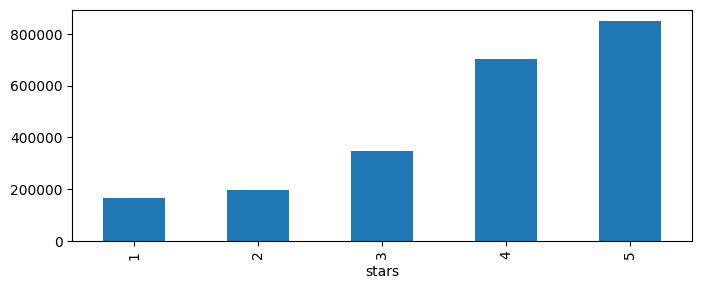

In [11]:
plt.subplots(figsize=(8,3))
review_df_sampled.groupby('stars').size().plot.bar();

Merge review.json with business.json to incorporate restaurant details.

## Model Based

In [12]:
algo = SVD(random_state=my_seed)

In [13]:
trainset, testset = train_test_split(review_data, test_size=.20, random_state=my_seed)

In [14]:
algo.fit(trainset);

In [15]:
predictions = algo.test(testset)
accuracy.rmse(predictions);
accuracy.mae(predictions);

RMSE: 1.0875
MAE:  0.8516


In [16]:
#needs 5 min to run
performance = cross_validate(algo, review_data, measures=['RMSE', 'MAE'],
                             cv=KFold(n_splits=5, random_state=my_seed),
                             return_train_measures=True, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0849  1.0865  1.0855  1.0882  1.0875  1.0865  0.0012  
MAE (testset)     0.8493  0.8509  0.8504  0.8528  0.8516  0.8510  0.0012  
RMSE (trainset)   0.7745  0.7750  0.7751  0.7746  0.7745  0.7748  0.0002  
MAE (trainset)    0.6069  0.6072  0.6072  0.6070  0.6067  0.6070  0.0002  
Fit time          61.76   60.74   61.59   55.86   29.68   53.93   12.31   
Test time         8.35    8.16    7.68    8.29    4.42    7.38    1.50    


In [27]:
uid='j6-SL-me3ZCbwpGS-sCbTA'
iid='yJ2ZRXx01eF40eRQFqIBeQ'

pred = algo.predict(uid, iid, r_ui=5, verbose=True)

user: j6-SL-me3ZCbwpGS-sCbTA item: yJ2ZRXx01eF40eRQFqIBeQ r_ui = 5.00   est = 4.49   {'was_impossible': False}


In [26]:
uid='j6-SL-me3ZCbwpGS-sCbTA'
given_user_df = review_df_sampled[review_df_sampled['user_id'] == uid].sort_values(by='stars', ascending=False)
given_user_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
284269,W80Vt6mTqtZ77csZ-V7AyA,j6-SL-me3ZCbwpGS-sCbTA,yJ2ZRXx01eF40eRQFqIBeQ,5,0,0,0,My favorite Mexican restaurant. BEAN DIP!!!!! ...,2017-12-29 02:36:02
349933,oaaoN5978bkj427c9bWMOw,j6-SL-me3ZCbwpGS-sCbTA,KOAz86HXkNKNvEExrGXxlQ,5,0,0,0,Very quick service via the drive through line....,2021-11-27 16:42:41
4154913,DTwuWjqlNoO6c5xsGSq1IQ,j6-SL-me3ZCbwpGS-sCbTA,AYKHW6Ff1ejhjWmyO5O6MA,5,0,0,0,"Very friendly staff, the manager was extremely...",2021-10-23 17:48:33
4129619,-EqvscdrUzDK1RmfRBwtwQ,j6-SL-me3ZCbwpGS-sCbTA,kAOn-rLmNnm0YM9x6mZ_6g,5,0,0,0,"My FAVORITE sushi restaurant. Tonight I had ""t...",2021-10-24 04:14:19
3699423,FkeM0DQUVyE-YV5pk1fxEA,j6-SL-me3ZCbwpGS-sCbTA,FkmUQqJCjgAYSlckQL0umw,5,0,0,0,Excellent food and service. The only thing I c...,2021-10-23 17:55:13


In [43]:
given_user_df.merge(business_df_sampled, on='business_id')[['name','city','attributes','categories']]

,name,city,attributes,categories
0,Casa Garcia Mexican Restaurant,Metairie,"{'WiFi': 'u'no'', 'RestaurantsTakeOut': 'True'...","Restaurants, Tex-Mex, Seafood, Mexican"
1,Chick-fil-A,Jefferson,"{'RestaurantsPriceRange2': '1', 'BikeParking':...","Caterers, Restaurants, Event Planning & Servic..."
2,Mantra Indian Cuisine,Metairie,"{'RestaurantsTableService': 'True', 'Restauran...","Vegan, Vegetarian, Indian, Restaurants"
3,Uchi Sushi,Metairie,"{'RestaurantsAttire': 'u'casual'', 'BikeParkin...","Restaurants, Japanese, Sushi Bars, Food"
4,Bobby Hebert's Cajun Cannon,Metairie,"{'GoodForKids': 'True', 'CoatCheck': 'False', ...","Seafood, American (New), Nightlife, Tapas/Smal..."
5,French Press Coffee House,Metairie,"{'GoodForMeal': '{'dessert': False, 'latenight...","Breakfast & Brunch, Coffee Roasteries, Cafes, ..."
6,Lee's Hamburgers,Metairie,"{'GoodForKids': 'True', 'RestaurantsAttire': '...","Restaurants, Burgers, Hot Dogs"
7,French Press Coffee House,Metairie,"{'GoodForMeal': '{'dessert': False, 'latenight...","Breakfast & Brunch, Coffee Roasteries, Cafes, ..."
8,Guillory's Deli & Tamales,Metairie,"{'WiFi': ''no'', 'Ambience': '{'touristy': Fal...","Restaurants, Food, Delis, Burgers, Grocery, Sa..."
9,Bear's Po Boy's at Gennaro's,Metairie,"{'RestaurantsPriceRange2': '2', 'HasTV': 'True...","Restaurants, Sandwiches, Seafood"


In [44]:
already_rated = given_user_df['business_id'].unique()
all_items = review_df_sampled['business_id'].unique()
items_to_rate = [x for x in all_items if x not in already_rated]

In [45]:
all_predictions = {}
for iid in items_to_rate:
  est = algo.predict(uid, iid).est
  all_predictions[iid] = est

In [46]:
len(all_predictions)

52037

In [47]:
top_10_items = sorted(all_predictions.items(), reverse=True, key=lambda x:x[1])[:10]
pd.DataFrame(top_10_items, columns=['business_id', 'stars']).merge(business_df_sampled, on='business_id')[['name','city', 'attributes','categories']]

,name,city,attributes,categories
0,Thai Place Restaurant,Phoenixville,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Thai, Restaurants"
1,HipCityVeg,Philadelphia,"{'RestaurantsAttire': 'u'casual'', 'NoiseLevel...","Burgers, Vegetarian, Restaurants, Vegan"
2,El Limon - Malvern,Malvern,"{'GoodForMeal': '{'dessert': False, 'latenight...","Mexican, Restaurants"
3,Blues City Deli,Saint Louis,"{'BikeParking': 'True', 'RestaurantsAttire': '...","Delis, Bars, Restaurants, Nightlife, Pubs, Ame..."
4,Sushi Ushi,Valrico,"{'OutdoorSeating': 'False', 'RestaurantsReserv...","Japanese, Sushi Bars, Restaurants"
5,Brick & Mortar,Saint Petersburg,"{'RestaurantsTableService': 'True', 'CoatCheck...","Nightlife, Bars, American (New), Restaurants, ..."
6,Bab Café - Reno,Reno,"{'RestaurantsDelivery': 'True', 'BikeParking':...","Restaurants, Cafes, Korean, Gluten-Free, Comfo..."
7,City Barbeque,Fishers,"{'RestaurantsAttire': ''casual'', 'OutdoorSeat...","Restaurants, Caterers, Barbeque, American (Tra..."
8,Jong Ka Jib,Philadelphia,"{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...","Korean, Restaurants"


In [48]:
pred_df = pd.DataFrame([(x.r_ui, x.est) for x in predictions],
                       columns=['true_rating', 'predicted_rating'])
pred_df.head()

,true_rating,predicted_rating
0,4.0,3.759934
1,5.0,3.429586
2,1.0,2.926318
3,4.0,3.339560
4,2.0,4.481970


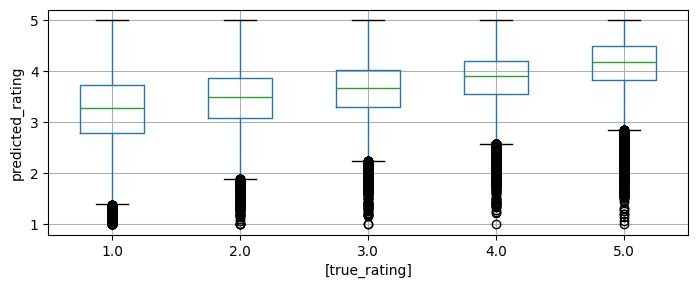

In [40]:
fig, ax = plt.subplots(figsize=(8,3))
bp = pred_df.boxplot(by="true_rating", ax=ax);

# Just aesthetic to format title and axis
bp.get_figure().suptitle('');
bp.get_figure().gca().set_title("");
bp.set_ylabel('predicted_rating');

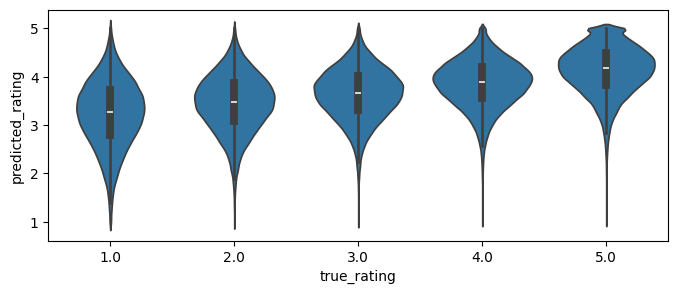

In [41]:
fig, ax = plt.subplots(figsize=(8,3))
sns.violinplot(data=pred_df, x="true_rating", y="predicted_rating");